# What Happened When Gradient is Almost Zero

## 采用的模型

| Model                                      | Parameter |
| deep model：     `1->5->10->10->10->10->10->5->1` |    571    |

> 注：上述模型采用Tanh作为激活函数
>
> 拟合函数1：$sin(5\pi x)/5\pi x$
>
> 训练采用的参数：`batch_size=250, optimizer=Adam(lr=1e-3), epoch=4000 `
>
> 在训练到2000轮的时候，换成以gradient norm为损失函数继续训练

In [1]:
import sys
sys.path.insert(0, '..')
import torch
from argparse import Namespace
from torch import optim, autograd
from model import deep_simulate
from model import mse_loss
from dataset import simulate_dataloader
from utils import ensure_dir, minimal_ratio, eval_gradnorm, Logger

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 参数设置
config = {'batch_size': 250, 'epochs': 4000, 'change_epoch': 2000, 'use_cuda': True,
          'lr': 1e-3, 'save_dir': '../pretrained/1_2_3', 'total_num': 100}
config = Namespace(**config)

In [4]:
ensure_dir(config.save_dir)
logger = Logger()
device = torch.device('cuda:0' if torch.cuda.is_available() and config.use_cuda else 'cpu')
train_loader = simulate_dataloader('sin', config.batch_size)
criterion = mse_loss

In [ ]:
# 训练阶段 --- 可能需要花费几小时, 请耐心等待～
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
for i in range(config.total_num):
    net = deep_simulate('sin_{}'.format(i)).to(device)
    opt = optim.Adam(net.parameters(), lr=config.lr, amsgrad=True)
    for epoch in range(1, config.epochs + 1):
        avg_loss, avg_loss_grad = 0.0, 0.0
        for idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            y_pred = net(x)
            opt.zero_grad()
            loss = criterion(y_pred, y)
            if epoch > config.change_epoch:
                loss_ls, avg_loss = loss.item(), avg_loss + loss.item()
                grads = autograd.grad(loss, net.parameters(), create_graph=True)
                loss = sum([grd.norm() ** 2 for grd in grads])
                loss_grad, avg_loss_grad = loss.item(), avg_loss_grad + loss.item()
            # we only evaluate minimal_ratio once
            if epoch == config.epochs and idx == len(train_loader) - 1:
                ratio = minimal_ratio(grads, net)
            loss.backward()
            opt.step()
        if epoch > config.change_epoch:
            print('epoch (after change): {}, avg_loss: {}, avg_grad: {}'.format(epoch, loss_ls, loss_grad))
        else:
            print('epoch (before change): {}, loss: {}'.format(epoch, loss))
    log = {
        'num': i,
        'avg_loss': avg_loss / (config.epochs - config.change_epochs),
        'avg_loss_grad': avg_loss_grad / (config.epochs - config.change_epochs),
        'loss': loss_ls,
        'loss_grad': loss_grad,
        'grad_norm': eval_gradnorm(net.parameters()),
        'min_ratio': ratio
    }
    print(log)
    logger.add_entry(log)
torch.save(logger, config.save_dir + '/minimum_ratio.pth.tar')

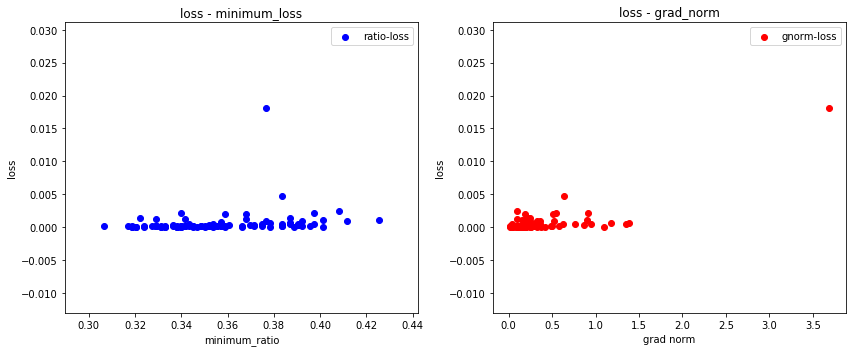

In [5]:
# 可视化结果
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title('loss - minimum_loss')
ax2.set_title('loss - grad_norm')
logger = torch.load(config.save_dir + '/minimum_ratio.pth.tar')
loss = [entry['loss'] for _, entry in logger.entries.items()]
ratio = [entry['min_ratio'] for _, entry in logger.entries.items()]
grad_norm = [entry['grad_norm'] for _, entry in logger.entries.items()]
ax1.scatter(ratio, loss, c='b', label='ratio-loss')
ax1.legend(loc="best")
ax1.set_xlabel('minimum_ratio')
ax1.set_ylabel('loss')
ax2.scatter(grad_norm, loss, c='r', label='gnorm-loss')
ax2.legend(loc="best")
ax2.set_xlabel('grad norm')
ax2.set_ylabel('loss')
plt.tight_layout()
plt.show()

### 结果分析

1. 说实话我并没看出什么规律来，整体而言loss都非常非常低了，而此时的minimum_ratio大致分布在0.3~0.42之间
2. 大部分模型都处于grad norm比较小的地方